In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py, csv

2024-04-03 00:16:09.411398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 00:16:09.451959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 00:16:10.118539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
# Model Definition
P3 = 128
# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # Text MSM Layers
    self.bigru_text = keras.layers.Bidirectional(keras.layers.GRU(512))
    self.msl_1_text = keras.layers.Dense(256, activation='relu')
    self.msl_2_text = keras.layers.Dense(P3, activation='relu')
    # Audio MSM Layers
    self.bigru_audio = keras.layers.Bidirectional(keras.layers.GRU(512))
    self.msl_1_audio = keras.layers.Dense(256, activation='relu')
    self.msl_2_audio = keras.layers.Dense(P3, activation='relu')
    # Visual MSM Layers
    self.bigru_visual = keras.layers.Bidirectional(keras.layers.GRU(512))
    self.msl_1_visual = keras.layers.Dense(256, activation='relu')
    self.msl_2_visual = keras.layers.Dense(P3, activation='relu')

  def __call__(self, text_input, audio_input, visual_input):
    # Text MSM
    bigru_text_output = self.bigru_text(text_input)
    msl_l1_text = self.msl_1_text(bigru_text_output)
    text_msm_output = self.msl_2_text(msl_l1_text)
    # Audio MSM
    bigru_audio_output = self.bigru_audio(audio_input)
    msl_l1_audio = self.msl_1_audio(bigru_audio_output)
    audio_msm_output = self.msl_2_audio(msl_l1_audio)
    # Visual MSM
    bigru_visual_output = self.bigru_visual(visual_input)
    msl_l1_visual = self.msl_1_visual(bigru_visual_output)
    visual_msm_output = self.msl_2_visual(msl_l1_visual)

    return text_msm_output, audio_msm_output, visual_msm_output


# Dense Multimodal Fusion Module
class DenseMultimodalFusionModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.residual_features = []

  def df_wrapper(self, f1, f2, f3, n):
    for i in range(n):
      f1, f2, f3 = self.df_layer(f1, f2, f3)
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    return self.residual_features

  # df layer
  def df_layer(self, f1, f2, f3):
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    # concatenation before feeding to df block
    df_input1 = keras.layers.Concatenate()([f1, f3])
    df_input2 = keras.layers.Concatenate()([f1, f2])
    df_input3 = keras.layers.Concatenate()([f2, f3])
    # df block
    df_output1 = keras.layers.Dense(P3, activation='relu')(df_input1)
    df_output2 = keras.layers.Dense(P3, activation='relu')(df_input2)
    df_output3 = keras.layers.Dense(P3, activation='relu')(df_input3)

    return df_output1, df_output2, df_output3

  def __call__(self, f1_0, f2_0, f3_0):
    DF_LAYER_COUNT = 16
    residual = self.df_wrapper(f1_0, f2_0, f3_0, DF_LAYER_COUNT)
    return residual


# Multimodal Residual Module
class MultimodalResidualModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, residual_features):
    final_residual_feature = keras.layers.Add()(residual_features)
    return final_residual_feature


# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 5
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, residual_feature):
    output_l1 = self.layer_1(residual_feature)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# deep dense fusion network with multimodal residual (DFMR)
class DFMR(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.text_input = keras.Input(shape=(1, 768))
    self.audio_input = keras.Input(shape=(1, 768))
    self.visual_input = keras.Input(shape=(5226, 512))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.dmfm = DenseMultimodalFusionModule()
    self.mrm = MultimodalResidualModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    text_msm_output, audio_msm_output, visual_msm_output = self.msm(self.text_input, self.audio_input, self.visual_input)
    residual_features = self.dmfm(text_msm_output, audio_msm_output, visual_msm_output)
    final_residual_feature = self.mrm(residual_features)
    output = self.scm(final_residual_feature)    
    # model definition
    model = keras.Model(inputs=[self.text_input, self.audio_input, self.visual_input], outputs=output)
    return model


dfmr_model = DFMR()
model = dfmr_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 5226, 512) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 1024)      │  3,938,304 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 1024)      │  3,938,304 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 1024)      │  3,151,872 │ input_layer_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 256)       │    262,400 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 256)       │    262,400 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 256)       │    262,400 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 128)       │     32,896 │ dense_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │     32,896 │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 128)       │     32,896 │ dense_63[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_48      │ (None, 256)       │          0 │ dense_60[0][0],   │
│ (Concatenate)       │                   │            │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 256)       │          0 │ dense_60[0][0],   │
│ (Concatenate)       │                   │            │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_50      │ (None, 256)       │          0 │ dense_62[0][0],   │
│ (Concatenate)       │                   │            │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 128)       │     32,896 │ concatenate_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 128)       │     32,896 │ concatenate_49[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 128)       │     32,896 │ concatenate_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_51      │ (None, 256)       │          0 │ dense_70[0][0],   │
│ (Concatenate)       │                   │            │ dense_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 256)       │          0 │ dense_70[0][0], 

 Total params: 13,520,837 (51.58 MB)

 Trainable params: 13,520,837 (51.58 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [3]:
audio_embeddings = {}
transcript_embeddings = {}
video_embeddings = {}

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/audio_embeddings.h5', 'r') as f:
  a_ids = list(f.keys())
  a_max_shape = f[a_ids[0]].shape
  for i in a_ids:
    audio_embeddings[i] = f[i][:]
    shape = f[i].shape
    if a_max_shape < shape:
      a_max_shape = shape
  
  for key,value in audio_embeddings.items():
    padded_value = np.pad(value, ((0, a_max_shape[0] - value.shape[0])), mode='constant')
    reshaped_value = padded_value.reshape((1, padded_value.shape[0]))
    audio_embeddings[key] = reshaped_value
    # print(audio_embeddings[key].shape)

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/transcript_embeddings.h5', 'r') as f:
  t_ids = list(f.keys())
  t_max_shape = f[t_ids[0]].shape
  for i in t_ids:
    transcript_embeddings[i] = f[i][:]
    shape = f[i].shape
    if t_max_shape < shape:
      t_max_shape = shape
      
  for key,value in transcript_embeddings.items():
    padded_value = np.pad(value, ((0, t_max_shape[0] - value.shape[0])), mode='constant')
    transcript_embeddings[key] = padded_value
    # print(transcript_embeddings[key].shape)

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/video_embeddings.h5', 'r') as f:
  v_ids = list(f.keys())
  v_max_shape = f[v_ids[0]].shape
  for i in v_ids:
    video_embeddings[i] = f[i][:]
    shape = f[i].shape
    if v_max_shape < shape:
      v_max_shape = shape

  for key,value in video_embeddings.items():
    padded_value = np.pad(value, ((0, v_max_shape[0] - value.shape[0]), (0, v_max_shape[1] - value.shape[1])), mode='constant')
    video_embeddings[key] = padded_value
    # print(video_embeddings[key].shape)

a_ids = v_ids
t_ids = v_ids

In [5]:
video_embeddings_list = []
for k in v_ids:
  video_embeddings_list.append(video_embeddings[k])
video_embeddings_array = np.array(video_embeddings_list)
v_eager_tensor = tf.convert_to_tensor(video_embeddings_array)
print(v_eager_tensor.shape)

audio_embeddings_list = []
for k in a_ids:
  audio_embeddings_list.append(audio_embeddings[k])
audio_embeddings_array = np.array(audio_embeddings_list)
a_eager_tensor = tf.convert_to_tensor(audio_embeddings_array)
print(a_eager_tensor.shape)

transcript_embeddings_list = []
for k in t_ids:
  transcript_embeddings_list.append(transcript_embeddings[k])
transcript_embeddings_array = np.array(transcript_embeddings_list)
t_eager_tensor = tf.convert_to_tensor(transcript_embeddings_array)
print(t_eager_tensor.shape)

(69, 5226, 512)
(69, 1, 768)
(69, 1, 768)


In [6]:
def convertLabels(label):
  rep = {
    -2 : [1., 0., 0., 0., 0.],
    -1 : [0., 1., 0., 0., 0.],
    0 : [0., 0., 1., 0., 0.],
    1 : [0., 0., 0., 1., 0.],
    2 : [0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[label])

text_input = t_eager_tensor
audio_input = a_eager_tensor
visual_input = v_eager_tensor

labels_dict = {}
labels_list = []
labels_path = '../../datasets/Dravidian Dataset/malayalam_data/labels/labels.csv'
with open(labels_path, newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  # removed MAL_MSA_18 since it has no video file
  for row,k in zip(reader, t_ids):
    labels_dict[k] = convertLabels(int(row['label']))
    labels_list.append(labels_dict[k])
labels_array = np.array(labels_list)
labels_eager_tensor = tf.convert_to_tensor(labels_array)
print(labels_eager_tensor.shape)

label_input = labels_eager_tensor

(69, 5)


In [7]:
text_train = text_input[0:55]
audio_train = audio_input[0:55]
visual_train = visual_input[0:55]
label_train = label_input[0:55]

text_validation = text_input[49:55]
audio_validation = audio_input[49:55]
visual_validation = visual_input[49:55]
label_validation = label_input[49:55]

text_test = text_input[59:62]
audio_test = audio_input[59:62]
visual_test = visual_input[59:62]
label_test = label_input[59:62]

train_dataset = [text_train, audio_train, visual_train]
validation_data = ([text_validation, audio_validation, visual_validation], label_validation)
test_dataset = [text_test, audio_test, visual_test]

In [10]:
print(f"Training Data Shape\n\tText: {text_train.shape}\n\tAudio: {audio_train.shape}\n\tVisual: {visual_train.shape}\n\tLabel: {label_train.shape}")

print(f"\nTraining Data type\n\tText: {type(text_train)}\n\tAudio: {type(audio_train)}\n\tVisual: {type(visual_train)}\n\tLabel: {type(label_train)}")


Training Data Shape
	Text: (55, 1, 768)
	Audio: (55, 1, 768)
	Visual: (55, 5226, 512)
	Label: (55, 5)

Training Data type
	Text: <class 'tensorflow.python.framework.ops.EagerTensor'>
	Audio: <class 'tensorflow.python.framework.ops.EagerTensor'>
	Visual: <class 'tensorflow.python.framework.ops.EagerTensor'>
	Label: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [11]:
print(text_train[0])

tf.Tensor(
[[ 1.92695844e-03 -8.79279338e-03  1.78817026e-02 -1.41239110e-02
  -1.10539449e-02  2.16621980e-02 -1.48284743e-02 -4.98855719e-03
  -1.80860814e-02  2.30145864e-02 -5.01082558e-03  1.91063937e-02
   3.70371155e-02 -2.71529481e-02  4.81437054e-03 -2.77643255e-03
   3.01040281e-02  1.17182592e-02  3.94651182e-02 -9.55123380e-02
   4.13387604e-02 -1.46309957e-02  2.23801304e-02  5.98556502e-03
  -1.63095742e-02  3.36988792e-02 -1.18119572e-03 -6.91050151e-03
  -1.23072304e-02  3.26369628e-02  8.25173873e-03 -1.83422472e-02
   2.08861697e-02  3.70750949e-02 -1.86714977e-02  2.49869190e-02
   4.28812094e-02  2.52871513e-02 -6.18561544e-03 -4.17310698e-03
  -9.00901556e-02 -2.28524227e-02  1.92971602e-02 -5.58064785e-03
   1.03797317e-02 -9.13030189e-03  2.27480978e-02  1.93759762e-02
  -2.36346968e-03  1.16840955e-02  4.34805220e-03  7.43383216e-03
   3.91500210e-03 -2.81897597e-02  2.28469912e-02 -6.91407220e-03
  -1.15732597e-02 -3.57084512e-03 -2.03891564e-02 -1.29839014e-02

In [12]:
print(audio_train[0])

tf.Tensor(
[[ 2.93789864e-01  1.02840088e-01  2.18223915e-01 -1.31202072e-01
  -7.65004233e-02 -2.56467909e-01 -1.24390841e-01  3.87024209e-02
  -2.06246957e-01  1.36343852e-01 -5.33557415e-01  1.03280470e-01
  -3.09596062e-01  7.30043724e-02  2.70042777e-01  9.28877480e-03
  -2.38511354e-01  2.79163986e-01  1.87255014e-02  2.88388938e-01
  -2.39262164e-01  3.45098913e-01  2.81139947e-02  1.07540917e-02
  -5.69360480e-02  1.68377250e-01 -8.41705650e-02  2.83343792e-01
   7.92264819e-01 -2.33337417e-01  1.51974469e-01 -1.07710592e-01
  -1.55506730e-01 -2.05549136e-01  2.45475948e-01  1.94353908e-01
   2.89067328e-01 -2.22491801e-01  2.27973014e-01  1.17122047e-01
   2.59572923e-01 -1.65058091e-01  1.95207596e-01  5.51193468e-02
   4.50659394e-01  1.00779012e-01 -2.18375593e-01 -1.04197823e-01
  -7.72319213e-02  2.27380991e-01  4.79381084e-01  3.51123814e-03
  -3.49999189e-01  9.26817954e-02  2.30046272e-01  1.71463087e-01
  -2.69248873e-01 -1.67461927e-03  4.28264737e-02  1.81765463e-02

In [14]:
print(visual_train[0])

tf.Tensor(
[[-1.79923845e+00 -1.47246145e+00  3.23208976e+00 ... -1.95663181e-01
  -9.05703231e-03  7.90234343e-03]
 [-1.03633684e+00 -1.73159323e+00  2.89097045e+00 ... -1.11445271e-01
   2.65148929e-02 -2.70488929e-03]
 [-6.42874063e-02 -1.82836073e+00  3.29391655e+00 ... -1.10512342e-01
  -8.74260185e-02 -7.74261441e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]], shape=(5226, 512), dtype=float64)


In [15]:
print(label_train[0])

tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


In [20]:
epochs = 100
history = model.fit(train_dataset, label_train, validation_data=validation_data, epochs=epochs)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 125s 41s/step - accuracy: 0.0000e+00 - loss: 0.3294 - val_accuracy: 0.0000e+00 - val_loss: 0.3257
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 36s/step - accuracy: 0.0000e+00 - loss: 0.2936 - val_accuracy: 0.0000e+00 - val_loss: 0.3331
Epoch 3/100


2024-04-02 19:10:40.242312: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 38s/step - accuracy: 0.0000e+00 - loss: 0.2115 - val_accuracy: 0.0333 - val_loss: 0.3333
Epoch 4/100


2024-04-02 19:11:54.471476: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 38s/step - accuracy: 0.0943 - loss: 0.2029 - val_accuracy: 0.0333 - val_loss: 0.3333
Epoch 5/100


2024-04-02 19:13:09.913993: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 39s/step - accuracy: 0.2023 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 6/100


2024-04-02 19:14:30.269188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 7/100


2024-04-02 19:15:47.760460: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 0.7892 - loss: 0.2080 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 8/100


2024-04-02 19:17:04.444869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 38s/step - accuracy: 0.8101 - loss: 0.1953 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 9/100


2024-04-02 19:18:21.386577: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 36s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 10/100


2024-04-02 19:19:34.607825: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 37s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 11/100


2024-04-02 19:20:48.147654: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 35s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 12/100


2024-04-02 19:22:00.894904: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 40s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 13/100


2024-04-02 19:23:18.361478: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 41s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 14/100


2024-04-02 19:24:39.704180: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 33s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 15/100


2024-04-02 19:25:54.459282: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 32s/step - accuracy: 0.7851 - loss: 0.2105 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 16/100


2024-04-02 19:27:01.809123: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 26s/step - accuracy: 0.7892 - loss: 0.2080 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 17/100


2024-04-02 19:27:55.219545: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 27s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 18/100


2024-04-02 19:28:48.361933: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 30s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 19/100


2024-04-02 19:29:46.520873: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 61s 30s/step - accuracy: 0.8101 - loss: 0.1953 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 20/100


2024-04-02 19:30:47.129615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 30s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 21/100


2024-04-02 19:31:46.404085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 29s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 22/100


2024-04-02 19:32:43.073652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 29s/step - accuracy: 0.7892 - loss: 0.2080 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 23/100


2024-04-02 19:33:41.705221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 29s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 24/100


2024-04-02 19:34:40.287634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 29s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 25/100


2024-04-02 19:35:39.703157: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 26/100


2024-04-02 19:36:34.373717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 29s/step - accuracy: 0.7892 - loss: 0.2080 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 27/100


2024-04-02 19:37:31.130840: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 61s 32s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 28/100


2024-04-02 19:38:32.030148: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 29/100


2024-04-02 19:39:26.880707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.7851 - loss: 0.2105 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 30/100


2024-04-02 19:40:22.428131: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.7851 - loss: 0.2105 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 31/100


2024-04-02 19:41:18.262477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 30s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 32/100


2024-04-02 19:42:18.413963: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.7892 - loss: 0.2080 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 33/100


2024-04-02 19:43:12.988827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 25s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 34/100


2024-04-02 19:44:04.270649: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 25s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 35/100


2024-04-02 19:44:56.115888: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 25s/step - accuracy: 0.8101 - loss: 0.1953 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 36/100


2024-04-02 19:45:47.264555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 27s/step - accuracy: 0.8059 - loss: 0.1978 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 37/100


2024-04-02 19:46:40.000813: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 25s/step - accuracy: 0.8101 - loss: 0.1953 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 38/100


2024-04-02 19:47:30.712021: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 26s/step - accuracy: 0.8184 - loss: 0.1902 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 39/100


2024-04-02 19:48:21.758543: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 28s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 40/100


2024-04-02 19:49:16.545245: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 26s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 41/100


2024-04-02 19:50:12.416505: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 25s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 42/100


2024-04-02 19:51:03.731398: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 28s/step - accuracy: 0.8059 - loss: 0.1978 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 43/100


2024-04-02 19:51:56.753909: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.7809 - loss: 0.2130 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 44/100


2024-04-02 19:52:52.310181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 28s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 45/100


2024-04-02 19:53:49.668188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 28s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 46/100


2024-04-02 19:54:46.369908: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.7851 - loss: 0.2105 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 47/100


2024-04-02 19:55:42.767202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 29s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 48/100


2024-04-02 19:56:42.419729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.7892 - loss: 0.2080 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 49/100


2024-04-02 19:57:38.825195: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 28s/step - accuracy: 0.7892 - loss: 0.2080 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 50/100


2024-04-02 19:58:36.259036: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 51/100


2024-04-02 19:59:32.260397: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 30s/step - accuracy: 0.7851 - loss: 0.2105 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 52/100


2024-04-02 20:00:32.472158: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 30s/step - accuracy: 0.7851 - loss: 0.2105 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 53/100


2024-04-02 20:01:32.619280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 26s/step - accuracy: 0.7851 - loss: 0.2105 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 54/100


2024-04-02 20:02:28.589274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 55/100


2024-04-02 20:03:23.148440: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 28s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 56/100


2024-04-02 20:04:18.273201: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 26s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 57/100


2024-04-02 20:05:11.015770: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 58/100


2024-04-02 20:06:07.169633: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 28s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 59/100


2024-04-02 20:07:01.979284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 60/100


2024-04-02 20:07:56.750120: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 30s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 61/100


2024-04-02 20:08:53.436042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.8059 - loss: 0.1978 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 62/100


2024-04-02 20:09:47.074706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.7809 - loss: 0.2130 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 63/100


2024-04-02 20:10:42.347829: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 26s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 64/100


2024-04-02 20:11:35.625049: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 65/100


2024-04-02 20:12:29.526907: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 26s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 66/100


2024-04-02 20:13:22.770372: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.8059 - loss: 0.1978 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 67/100


2024-04-02 20:14:16.389572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 28s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 68/100


2024-04-02 20:15:13.125517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 66s 34s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 69/100


2024-04-02 20:16:19.143948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 62s 28s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 70/100


2024-04-02 20:17:21.292939: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 28s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 71/100


2024-04-02 20:18:19.744918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 28s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 72/100


2024-04-02 20:19:18.024549: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 29s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 73/100


2024-04-02 20:20:16.767067: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 28s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 74/100


2024-04-02 20:21:14.643488: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 62s 33s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 75/100


2024-04-02 20:22:16.800717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342688384 bytes after encountering the first element of size 342688384 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 315s 137s/step - accuracy: 0.7976 - loss: 0.2029 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 76/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 86s 38s/step - accuracy: 0.7809 - loss: 0.2130 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 77/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 78/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 36s/step - accuracy: 0.8101 - loss: 0.1953 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 79/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 37s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 80/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 36s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 81/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 36s/step - accuracy: 0.7934 - loss: 0.2054 - val_accuracy: 0.6667 - val_loss: 0.3333
Epoch 82/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 72s 36s/step - accuracy: 0.8017 - loss: 0.2004 - val_accuracy: 0.6667 - val_loss: 0.

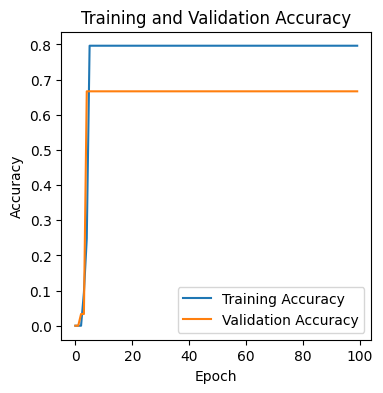

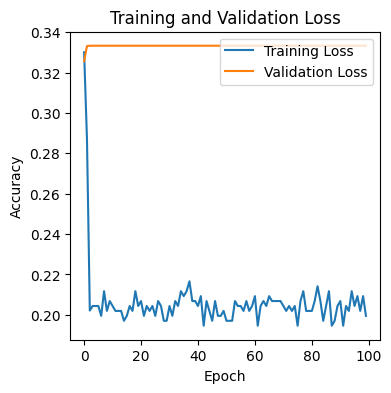

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, label_test)
print("test loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7333 - loss: 0.2667
test loss, test acc: [0.2666666805744171, 0.7333333492279053]
